In [42]:
# Import needed packages and potential data science tools like pandas and numpy
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from xgboost import XGBClassifier
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, StackingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import Ridge
from sklearn.metrics import *
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from imblearn.pipeline import Pipeline as ImblearnPipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPRegressor,MLPClassifier
from sklearn.naive_bayes import CategoricalNB, ComplementNB
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from scikeras.wrappers import KerasRegressor, KerasClassifier
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sn

## Introduction 

Neural Networks are a fundamental aspect of deep learning, capable of modeling complex relationships in data.  In this lab, we aimed to predict the presence of diabetes using data from the Centers for Disease Control and Prevention (CDC), specifically the Behavioral Risk Factor Surveillance System (BRFSS). Our primary goal was to build and evaluate various neural network models to determine their effectiveness in binary classification for predicting diabetes, and compare their performance to any other best method we have utilized.  To allow for a controlled comparison in usage and performance metrics of two differing models, I chose to utilize the balanced dataset with 50% of cases each having diabetes and not, which does not give an unfair advantage to methods that are well-versed in handling imbalanced like XGBoost.


## Data Preparation

In [30]:
# Read-in the data, naming our df in context
diabetes_data = pd.read_csv("/Users/rileysvensson/Desktop/GSB 545 - Advanced Machine Learning/archive (4)/diabetes_binary_5050split_health_indicators_BRFSS2015.csv") 

In [31]:
# When viewing the data it displays a very clean set with pre-scaled values for income and other features

# Check for missing values before modeling, displaying no issues 
diabetes_data.isnull().sum()

# Renaming a few variables to be more descriptive of the column 
diabetes_data.rename(columns={ 'MentHlth': 'PoorGenHealth_Days', 'PhysHlth': 'PoorPhysHealth_Days',
                                'GenHlth': 'GeneralHealth_Rating'}, inplace=True)

# Define column transformer to be used for preprocessing 
ct_all = ColumnTransformer(
  [
    ("dummify", OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize", StandardScaler(), make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough" 
).set_output(transform = "pandas")

# View head of the data to prepare for modeling
diabetes_data.head(5)

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GeneralHealth_Rating,PoorGenHealth_Days,PoorPhysHealth_Days,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,3.0,5.0,30.0,0.0,1.0,4.0,6.0,8.0
1,0.0,1.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0
2,0.0,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,10.0,0.0,1.0,13.0,6.0,8.0
3,0.0,1.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,3.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0
4,0.0,0.0,0.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0


This dataset required no cleaning or pre-processing due to its completeness and perfectly balanced target variable, Binary Diabetes, which allowed me to focus on understanding the effects of various features within our models. Before modeling, I sought to contextualize the growing issue of diabetes in the US, aiming to confirm hypotheses and previous findings with current data. Given the large potential feature set, it is optimal to identify and remove features that have no effect on a person's diabetes status. To research this, I visited the CDC's page on diabetes risk factors to confirm key influences on diabetes. The CDC warns that diabetes is more prevalent among elderly and overweight individuals, and those with family history risks (not captured in our variables). The relevant predictors in our dataset include `Age`, `HighChol`, `HighBP`, `PhysActivity`, `BMI` and `General Health`.

To understand these factors true predictive affect on if a patient has Diabetes or not, we can leverage an initial Logistic Regression model, to return the slope's or overall impact that each predictor has on Diabetes.  Logistic regression relies on the use of probabilities to predict a case of diabetes as 1 or 0, based on a percentage likelihood cutoff which is typically 0.50.  Along with this logistic model, we created a few interaction terms to test for any additional significant relationships between variables like Income and HighBP, as it could be expected that high income individuals have more income in which they are able to spend on healthy food, exercise memberships, and therefore better overall health (less risk for Diabetes). 

## Logistic Regression

In [32]:
# Drop 'Diabetes_binary' as the target column
X = diabetes_data.drop('Diabetes_binary', axis=1)
y = diabetes_data['Diabetes_binary']

# Create interaction terms
diabetes_data['Income_BMI'] = diabetes_data['Income'] * diabetes_data['BMI']
diabetes_data['Income_HighBP'] = diabetes_data['Income'] * diabetes_data['HighBP']
diabetes_data['Income_HighChol'] = diabetes_data['Income'] * diabetes_data['HighChol']


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)

# Using ct_all which is already defined
logistic_regression_pipeline = Pipeline([
    ("preprocessor", ct_all),
    ("logisticregressor", LogisticRegression(max_iter=1000, solver='lbfgs'))
])

# Define the parameter grid
param_grid = {
    'logisticregressor__C': [0.1, 1, 10], 
    'logisticregressor__penalty': ['l2'] 
}

# Tuning with GridSearchCV, using 'accuracy' as the scoring metric for classification
grid_search = GridSearchCV(logistic_regression_pipeline, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best parameters: ", grid_search.best_params_)
print("Best accuracy: ", grid_search.best_score_)

# Re-predict on the test set
test_predictions = grid_search.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
print("Test set accuracy: ", test_accuracy)

Best parameters:  {'logisticregressor__C': 10, 'logisticregressor__penalty': 'l2'}
Best accuracy:  0.7462816647687838
Test set accuracy:  0.7506601282534893


## Feature Effect Interpretation

In [18]:
import statsmodels.api as sm

# Fit the logistic regression model using stats models function
model = sm.Logit(y_train, X_train).fit()

# Print the summary of the model to see the coefficients and p-values
model.summary()

Optimization terminated successfully.
         Current function value: 0.525569
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        Diabetes_binary   No. Observations:                49484
Model:                          Logit   Df Residuals:                    49459
Method:                           MLE   Df Model:                           24
Date:                Mon, 13 May 2024   Pseudo R-squ.:                  0.2418
Time:                        14:25:56   Log-Likelihood:                -26007.
converged:                       True   LL-Null:                       -34300.
Covariance Type:            nonrobust   LLR p-value:                     0.000
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
HighBP                   0.3802      0.065      5.808      0.000       0.252       0.509
HighChol                 0.3451      0.062      5.532      0.000       0.223       0.467
CholCheck                0.1534      0.071      2.175      0.030       0.015       0.292
BMI                     -0.0359      0.003    -12.185      0.000      -0.042      -0.030
Smoker                  -0.0686      0.022     -3.095      0.002      -0.112      -0.025
Stroke                   0.1671      0.049      3.439      0.001       0.072       0.262
HeartDiseaseorAttack     0.3411      0.034     10.146      0.000       0.275       0.407
PhysActivity            -0.1070      0.025     -4.304      0.000      -0.156      -0.058
Fruits                  -0.2847      0.060     -4.738      0.000      -0.403      -0.167
Veggies                 -0.1167      0.027     -4.259      0.000      -0.170      -0.063
HvyAlcoholConsump       -0.8249      0.058    -14.256      0.000      -0.938      -0.711
AnyHealthcare           -0.2903      0.054     -5.413      0.000      -0.395      -0.185
NoDocbcCost             -0.1569      0.039     -4.050      0.000      -0.233      -0.081
GeneralHealth_Rating     0.4574      0.013     35.279      0.000       0.432       0.483
PoorGenHealth_Days      -0.0071      0.001     -4.746      0.000      -0.010      -0.004
PoorPhysHealth_Days     -0.0028      0.001     -1.999      0.046      -0.006   -5.39e-05
DiffWalk                 0.1953      0.030      6.433      0.000       0.136       0.255
Sex                      0.1945      0.023      8.626      0.000       0.150       0.239
Age                      0.1065      0.004     24.266      0.000       0.098       0.115
Education               -0.1420      0.012    -12.197      0.000      -0.165      -0.119
Income                  -0.6790      0.018    -37.509      0.000      -0.715      -0.644
Income_BMI               0.0172      0.001     29.682      0.000       0.016       0.018
Income_HighBP            0.0699      0.011      6.575      0.000       0.049       0.091
Income_HighChol          0.0472      0.010      4.599      0.000       0.027       0.067
Income_Fruit             0.0438      0.010      4.394      0.000       0.024       0.063
========================================================================================
"""

In terms of factors associated with Diabetes, we can look into the summary results of our Logistic Regression model, typically utilized when predicting a binary (2 categories) target variable.  The statsmodels package within Python allows us to easily refer to logistic regression summary statistics, providing additional information beyond simple slope coefficient's, such as p-values and confidence intervals.  Based on these predictive effects, we can see that every one has a significant impact on Diabetes status, when applying an alpha level or significance threshold of 0.05.  After running a few different iterations, I noticed slightly differing results in terms of statistical significance within the variables `CholCheck` and `PoorPhysicalHealthDays` showing an insigificant impact at times.  To account for this variability, I elected to use a higher p-value cutoff than 0.05, of 0.01, which warrented me to remove these insignifcant variables with p-values of 0.046 and 0.03.  In terms of our tested interactions, all of which result in statistically significant p-values, indicating that they contribute meaningfully to the model, beyond the main effects of the individual variables. 

However, it is interesting to interpret the slope coefficient of our interactions, to ensure that we can explain and udnerstand the underlying impact of each interaction on our target variable, Diabtes.  The positive coefficient's for all three interaction term's: `Income_BMI`, `Income_HighBP`, and `Income_HighChol`, indicate that as both BMI and income increase, the combined effect on the likelihood of diabetes increases. This may seem counterintuitive from our hypothesis earlier, however there are several factors that could explain this relationship. First off, higher income individuals might have better access to healthcare and therefore are more likely to be diagnosed with diabetes if they have a high BMI/Chol/BP. Additionally, higher income does not necessarily equate to healthier lifestyle choices, as people with higher incomes might have more opportunities to indulge in behaviors that contribute to higher BMI/Chol/BP, such as eating out frequently or consuming high-calorie foods.  Now that we understand the significant factors that contribute to diabetes, we can move into modeling with more complex solutions like Keras' Neural Networks and Stacking Model's to improve our decent accuracy of 75%.

## Model 1: Keras Neural Network

In [33]:
# Step 1: Preprocess the data

# Drop 'Diabetes_binary' due to it being our target column & drop insignificant predictors
X = diabetes_data.drop(['Diabetes_binary','PoorPhysHealth_Days', 'CholCheck'], axis=1)
y = diabetes_data['Diabetes_binary']

# Normalize features using a standard scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Specify numbers of features which will be used for the input shape 
number_of_features = len(X.columns)

# Step 2: Build the model
model = Sequential([
    Input(shape=(number_of_features,)),
    Dense(12, activation='relu'),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Step 3: Compile the model
model.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

# Step 4: Train the model
model.fit(X_train, y_train, epochs=20, batch_size=10, verbose=1)

# Step 5: Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Test accuracy:', accuracy)


Epoch 1/20
4949/4949 ━━━━━━━━━━━━━━━━━━━━ 1s 237us/step - accuracy: 0.7203 - loss: 0.5413
Epoch 2/20
4949/4949 ━━━━━━━━━━━━━━━━━━━━ 1s 234us/step - accuracy: 0.7484 - loss: 0.5074
Epoch 3/20
4949/4949 ━━━━━━━━━━━━━━━━━━━━ 1s 233us/step - accuracy: 0.7540 - loss: 0.5035
Epoch 4/20
4949/4949 ━━━━━━━━━━━━━━━━━━━━ 1s 235us/step - accuracy: 0.7543 - loss: 0.5033
Epoch 5/20
4949/4949 ━━━━━━━━━━━━━━━━━━━━ 1s 234us/step - accuracy: 0.7513 - loss: 0.5044
Epoch 6/20
4949/4949 ━━━━━━━━━━━━━━━━━━━━ 1s 233us/step - accuracy: 0.7544 - loss: 0.5021
Epoch 7/20
4949/4949 ━━━━━━━━━━━━━━━━━━━━ 1s 233us/step - accuracy: 0.7525 - loss: 0.5054
Epoch 8/20
4949/4949 ━━━━━━━━━━━━━━━━━━━━ 1s 236us/step - accuracy: 0.7540 - loss: 0.5032
Epoch 9/20
4949/4949 ━━━━━━━━━━━━━━━━━━━━ 1s 235us/step - accuracy: 0.7496 - loss: 0.5061
Epoch 10/20
4949/4949 ━━━━━━━━━━━━━━━━━━━━ 1s 234us/step - accuracy: 0.7528 - loss: 0.5029
Epoch 11/20
4949/4949 ━━━━━━━━━━━━━━━━━━━━ 1s 234us/step - accuracy: 0.7568 - loss: 0.4983
Epoch 12

## Model 2: Keras Neural Network - Feature Selection & Tuning

In [34]:
# Specify numbers of features which will be used for the input shape 
number_of_features = len(X.columns)

# Step 2: Build the model
model = Sequential([
    Input(shape=(number_of_features,)),
    Dense(64, activation='relu'),      # Increased neurons
    Dropout(0.3),                   
    Dense(32, activation='relu'),  
    Dropout(0.3),                     # Dropout used to apply regularization
    Dense(16, activation='relu'),   
    Dropout(0.3),                      # Added more dense layer's
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Step 3: Compile the model
model.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

# Step 4: Train the model
model.fit(X_train, y_train, epochs=20, batch_size=10, verbose=1)

# Step 5: Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Test accuracy:', accuracy)


Epoch 1/20
4949/4949 ━━━━━━━━━━━━━━━━━━━━ 2s 326us/step - accuracy: 0.7161 - loss: 0.5586
Epoch 2/20
4949/4949 ━━━━━━━━━━━━━━━━━━━━ 2s 324us/step - accuracy: 0.7508 - loss: 0.5185
Epoch 3/20
4949/4949 ━━━━━━━━━━━━━━━━━━━━ 2s 325us/step - accuracy: 0.7457 - loss: 0.5182
Epoch 4/20
4949/4949 ━━━━━━━━━━━━━━━━━━━━ 2s 323us/step - accuracy: 0.7491 - loss: 0.5144
Epoch 5/20
4949/4949 ━━━━━━━━━━━━━━━━━━━━ 2s 322us/step - accuracy: 0.7499 - loss: 0.5116
Epoch 6/20
4949/4949 ━━━━━━━━━━━━━━━━━━━━ 2s 322us/step - accuracy: 0.7523 - loss: 0.5095
Epoch 7/20
4949/4949 ━━━━━━━━━━━━━━━━━━━━ 2s 320us/step - accuracy: 0.7490 - loss: 0.5144
Epoch 8/20
4949/4949 ━━━━━━━━━━━━━━━━━━━━ 2s 323us/step - accuracy: 0.7517 - loss: 0.5100
Epoch 9/20
4949/4949 ━━━━━━━━━━━━━━━━━━━━ 2s 321us/step - accuracy: 0.7537 - loss: 0.5069
Epoch 10/20
4949/4949 ━━━━━━━━━━━━━━━━━━━━ 2s 326us/step - accuracy: 0.7492 - loss: 0.5133
Epoch 11/20
4949/4949 ━━━━━━━━━━━━━━━━━━━━ 2s 321us/step - accuracy: 0.7510 - loss: 0.5086
Epoch 12

Following the removal of insignificant variables found during exploratory logistic regression and the addition of more neural network layers, parameters and regularization with dropout, our accuracy rate of 75% still showed almost no change suggesting a maximum.  **Even then, an accuracy of above 70% in practical data sources suggest a highly successful model, that can have many usages within hospital, personal, and even insurance contexts.**

## Model 3 - Stacked Model 

1. Base Models - XgBoost, AdaBoost, MLPClassifier, Random Forest
2. Final Meta-Model - Logistic Regression

In this ensemble approach, we have built the following base models (XgBoost, AdaBoost, MLPClassifier, and Random Forest) each contribute to making initial predictions. These models are selected for their diverse strengths in handling different types of data and capturing various patterns. The predictions from these base models are then used as inputs for the final meta-model, which in this case is Logistic Regression. The Logistic Regression model synthesizes these inputs to produce a final prediction, leveraging the combined knowledge of the base models to enhance overall performance and robustness.

In [46]:
# Drop 'Diabetes_binary' due to it being our target column & drop insignificant predictors
X = diabetes_data.drop(['Diabetes_binary', 'PoorPhysHealth_Days', 'CholCheck'], axis=1)
y = diabetes_data['Diabetes_binary']

# Define column transformer to be used for preprocessing
ct_all = ColumnTransformer(
  [
    ("dummify", OneHotEncoder(sparse_output=False, handle_unknown='ignore'),
     make_column_selector(dtype_include=object)),
    ("standardize", StandardScaler(), make_column_selector(dtype_include=np.number))
  ],
  remainder="passthrough"
).set_output(transform="pandas")


# Apply the column transformer to the entire dataset
X_preprocessed = ct_all.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.3, random_state=42)

# Define base models within the preprocessing pipeline and tuned parameteres with usual best performers
base_models = [
    ('gradient_boosting', Pipeline([
        ('classifier', GradientBoostingClassifier(learning_rate=0.1, max_depth=4, n_estimators=300))
    ])),
    ('xgbboost', Pipeline([
        ('classifier', XGBClassifier(learning_rate = 0.3, max_depth = 4, n_estimators = 300))
    ])), 
    ('mlp_classifier', Pipeline([
        ('preprocessor', ct_all),
        ('classifier', MLPClassifier(activation = 'relu', hidden_layer_sizes = (100,), 
                                     learning_rate = 'constant', solver = 'adam', max_iter = 1000,
                                     early_stopping = True))
    ])),
    ('ada_boost', Pipeline([
        ('classifier', AdaBoostClassifier(algorithm ='SAMME', n_estimators = 300,
                                          learning_rate = 0.1 ))
     ])),
    ('random_forest', Pipeline([
        ('classifier', RandomForestClassifier(max_depth = None, min_samples_leaf = 1,
                                              n_estimators = 150))
    ]))
]

# Define the final regressor method, typically Linear or Logistic, in this case for classification use Log
final_regressor = LogisticRegression()

# Create the stacking ensemble
stacking_classifier = StackingClassifier(estimators=base_models, final_estimator=final_regressor, cv=5)

# Fit the stacking model on train data
stacking_classifier.fit(X_train, y_train)

# Predict/evaluate the model on Test data
stacking_predictions = stacking_classifier.predict(X_test)
stacking_accuracy = accuracy_score(y_test, stacking_predictions)

# Stacking model performance including final feature set
print("Stacking Model Test Accuracy:", stacking_accuracy)

Stacking Model Test Accuracy: 0.7533477932855526


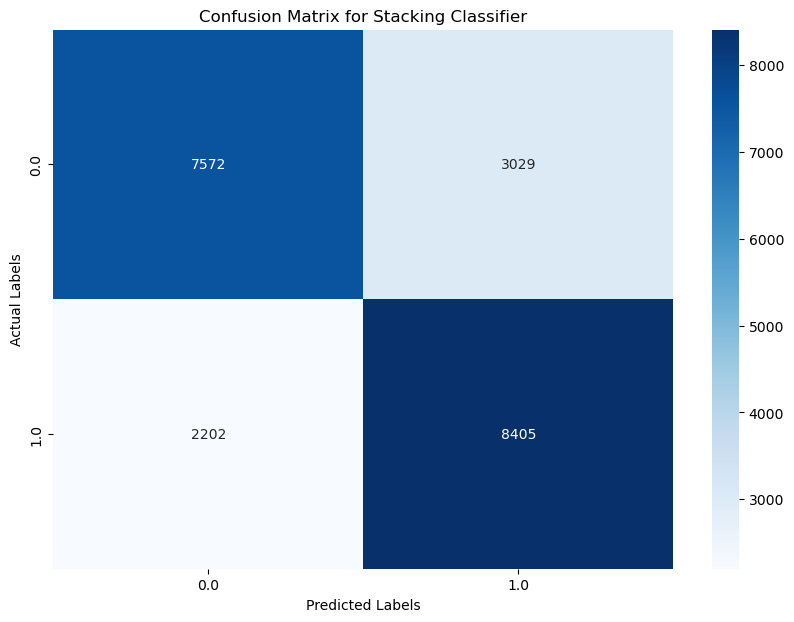

In [52]:
# Generate the confusion matrix, using labels from the classifier
labels = stacking_classifier.classes_ 
cm = confusion_matrix(y_test, stacking_predictions, labels=labels)

# Plotting the confusion matrix using Seaborn
plt.figure(figsize=(10, 7))
sn.heatmap(cm, annot=True, cmap='Blues', cbar=True, fmt='d',
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix for Stacking Classifier')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()

## Discussion of Results 

Its no suprise that the Stacking Model achieved the highest a test accuracy of 75.33%, while both the Keras Neural Network and Logistic Regression models came in closely behind with a test accuracy of 75.30% and 75%.  However this was far closer in performance that we typically see between methods, and in this case the final meta-model was unable to learn significantly more than even a simple logistic regression. These consistent results were expected with the clean and well-preprocessed data, alowing us to effectively capture the underlying patterns related to diabetes prediction. When examining the factors associated with diabetes, the Logistic Regression model revealed some interesting insights. **Factors positively associated with diabetes include high blood pressure, high cholesterol, stroke history, heart disease, poor general health rating, difficulty walking, being male, and older age, mostly all of which are obvious aside from gender.** On the flip side, variables **negatively associated with diabetes are BMI, physical activity, fruit and vegetable consumption, access to healthcare, education, and higher income.**  The remaining factors within the model, although statistically significant, were likely unaffecting of having diabetes, while the features discussed above had high z-scores as well, meaning that they have a large effect.  It was surprising to find that being a smoker has seemingly no effect on diabetes status, along with poor physical health days which could be random or self-inflicted. 

Once again, the interaction terms (`Income_BMI`, `Income_HighBP`, and `Income_HighChol`) showed a positive association with diabetes, which suggests that as both BMI and income increase, the likelihood of diabetes also rises. This might seem counterintuitive initially, but makes sense when you consider that higher-income individuals might have better access to healthcare, leading to more frequent diabetes diagnoses if they have high BMI, cholesterol, or blood pressure. Additionally, people with higher incomes might indulge more in eating out and consuming high-calorie foods, contributing to higher BMI, cholesterol, or blood pressure, and thus increasing their risk of diabetes. Finally, when inspecting the final confusion matrix of our stacking model predictions, we are able to visualize our success, correctly predicting 8,405 diabetic cases and 7,572 non-diabetics. **In terms of the cost of misclassifications, our model aims at minimizing the false negatives in which we predict someone to be clear of diabetes risk, when they will eventually develop it or have it already requiring treatment.  In this case, our false negatives are 2,202 which is a large value but in context serves as our smallest cases of a prediction group (TP, FP, TN, FN) which is a good sign.** We incorrectly predicted 3,029 people to have diabetes when they did not, however this likely means that these individuals share similar traits as diabetic's, indicating that they should be monitored and practice the negatively associated factors above that can be controlled.  

### Sources

[Diabetes Risk Factors - CDC](https://www.cdc.gov/diabetes/basics/risk-factors.html)